In [ ]:
import os.path as osp
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
from PIL import Image
import json
from PIL import Image

import albumentations as A
from shapely.geometry import Polygon

In [134]:
def simple_show(img:Any,title:str="")->None:
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

def simple_shows(args: list[dict[str, Any]]) -> None:
    len_args = len(args)
    try:
        heights = [img.size[1] for img in [arg['img'] for arg in args]]
        widths = [img.size[0] for img in [arg['img'] for arg in args]]
    except Exception:
        heights = [np.array(arg['img']).shape[0] for arg in args]
        widths = [np.array(arg['img']).shape[1] for arg in args]
    
    avg_height = sum(heights) / len_args
    avg_width = sum(widths) / len_args
    aspect_ratio = avg_height / avg_width

    fig_width = len_args * 4
    fig_height = fig_width * aspect_ratio
    
    fig, axs = plt.subplots(1, len_args, figsize=(fig_width, fig_height))
    for i in range(len_args):
        title = args[i].get('title', '')
        img = args[i].get('img', None)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(title)
    
    plt.tight_layout()
    plt.show()

In [61]:
def _infer_dir(fname):
    lang_indicator = fname.split('.')[1]
    if lang_indicator == 'zh':
        lang = 'chinese'
    elif lang_indicator == 'ja':
        lang = 'japanese'
    elif lang_indicator == 'th':
        lang = 'thai'
    elif lang_indicator == 'vi':
        lang = 'vietnamese'
    else:
        raise ValueError
    return osp.join('../data', f'{lang}_receipt', 'img', 'train')

In [62]:
_lang_list = ['chinese', 'japanese', 'thai', 'vietnamese']

total_anno = dict(images=dict())
for nation in _lang_list:
    with open(osp.join('../data', '{}_receipt/ufo/{}.json'.format(nation, 'train')), 'r', encoding='utf-8') as f:
        anno = json.load(f)
    for im in anno['images']:
        total_anno['images'][im] = anno['images'][im]

    anno = total_anno
    image_fnames = sorted(anno['images'].keys())

In [100]:
idx = 3

In [101]:
image_fname = image_fnames[idx]
image_fpath = osp.join(_infer_dir(image_fname), image_fname)
original_image = Image.open(image_fpath)

vertices, labels = [], []
for word_info in anno['images'][image_fname]['words'].values():
    num_pts = np.array(word_info['points']).shape[0]
    if num_pts > 4:
        continue
    vertices.append(np.array(word_info['points']).flatten())
    labels.append(1)
vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)

### Rotate

In [65]:
def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])

def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4,2)).T
    if anchor is None:
        anchor = v[:,:1]
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)

def rotate_img(img, vertices, angle_range=10):
    '''rotate image [-10, 10] degree to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        angle_range : rotate range
    Output:
        img         : rotated PIL Image
        new_vertices: rotated vertices
    '''
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i,:] = rotate_vertices(vertice, -angle / 180 * math.pi, np.array([[center_x],[center_y]]))
    return img, new_vertices

### Resize

In [68]:
def resize_img(img, vertices, size):
    h, w = img.height, img.width
    ratio = size / max(h, w)
    if w > h:
        img = img.resize((size, int(h * ratio)), Image.BILINEAR)
    else:
        img = img.resize((int(w * ratio), size), Image.BILINEAR)
    new_vertices = vertices * ratio
    return img, new_vertices

### adjust height

In [71]:
def adjust_height(img, vertices, ratio=0.2):
    '''adjust height of image to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        ratio       : height changes in [0.8, 1.2]
    Output:
        img         : adjusted PIL Image
        new_vertices: adjusted vertices
    '''
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * (new_h / old_h)
    return img, new_vertices

### Crop

In [74]:
def is_cross_text(start_loc, length, vertices):
    '''check if the crop image crosses text regions
    Input:
        start_loc: left-top position
        length   : length of crop image
        vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
        True if crop image crosses text region
    '''
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array([start_w, start_h, start_w + length, start_h, start_w + length, start_h + length,
                  start_w, start_h + length]).reshape((4, 2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4, 2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99:
            return True
    return False

In [75]:
def crop_img(img, vertices, labels, length):
    '''crop img patches to obtain batch and augment
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        length      : length of cropped image region
    Output:
        region      : cropped image region
        new_vertices: new vertices in cropped region
    '''
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert(ratio_w >= 1 and ratio_h >= 1)

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:,[0,2,4,6]] = vertices[:,[0,2,4,6]] * ratio_w
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels==1,:])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:,[0,2,4,6]] -= start_w
    new_vertices[:,[1,3,5,7]] -= start_h
    return region, new_vertices

### Color Jitter & Normalize

In [129]:
image = original_image
if original_image.mode != 'RGB':
    image = original_image.convert('RGB')
image = np.array(image)

In [144]:
funcs = []
funcs.append(A.ColorJitter(p=1))
funcs.append(A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = A.Compose(funcs)

### Image Show

In [136]:
resize_image, vertices = resize_img(original_image, vertices, 2048)

simple_shows([{
    'img':original_image,
    'title':"Original Image"
},{
    'img':resize_image,
    'title':"Resize Image"
}])

In [137]:
rotate_image, vertices = rotate_img(original_image, vertices)

simple_shows([{
    'img':original_image,
    'title':"Original Image"
},{
    'img':rotate_image,
    'title':"Rotated Image"
}])

In [138]:
crop_image, vertices = crop_img(original_image, vertices, labels, 1024)

simple_shows([{
    'img':original_image,
    'title':"Original Image"
},{
    'img':crop_image,
    'title':"Crop Image"
}])

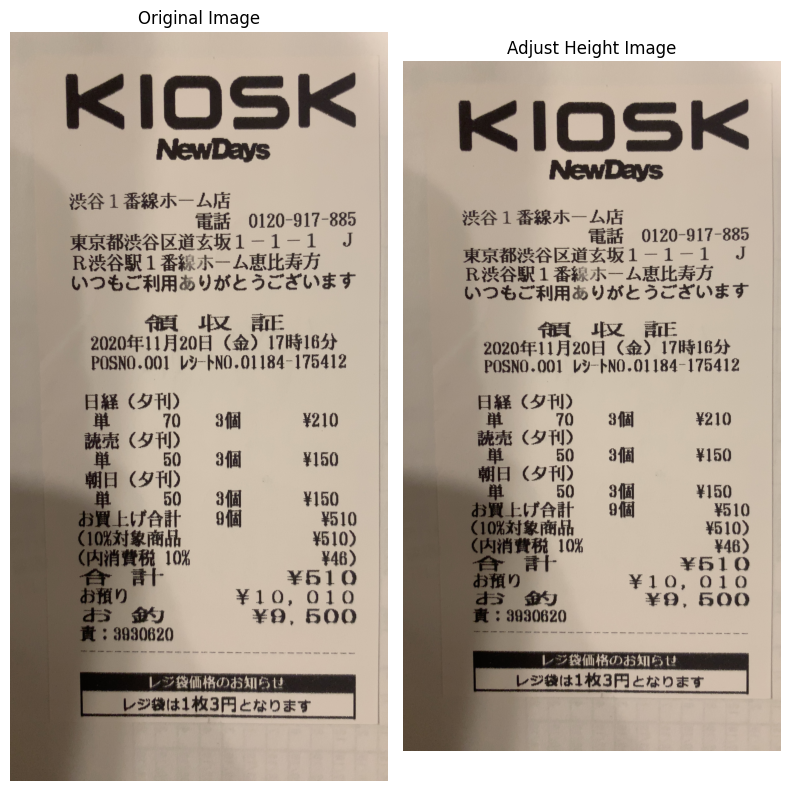

In [140]:
adjust_height_image, vertices = adjust_height(original_image, vertices)

simple_shows([{
    'img':original_image,
    'title':"Original Image"
},{
    'img':adjust_height_image,
    'title':"Adjust Height Image"
}])

In [145]:
color_image = transform(image=image)['image']

simple_shows([{
    'img':original_image,
    'title':"Original Image"
},{
    'img':color_image,
    'title':"color Image"
}])